In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
def preprocess_data(filename, N, points_prior):
    """
    Returns a DataFrame with:
      - target column 'OT' at time t
      - feature columns built only from times <= t - points_prior
      - calendar time features
    """
    df = pd.read_csv(filename)
    df = df.sort_values('date').reset_index(drop=True)  # ensure chronological

    load_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
    assert 'OT' in df.columns, "Expected target column 'OT' in CSV"
    assert 'date' in df.columns, "Expected time column 'date' in CSV"

    # Build features in a dict to avoid fragmentation
    feat = {}

    # Rolling stats (computed then shifted by points_prior)
    for col in load_cols:
        roll_mean = df[col].rolling(window=N, min_periods=N).mean().shift(points_prior)
        roll_std  = df[col].rolling(window=N, min_periods=N).std().shift(points_prior)
        feat[f'rolling_mean_{col}'] = roll_mean
        feat[f'rolling_std_{col}']  = roll_std

    # Lags (start from 1 up to N, then add points_prior)
    # These lags are ALWAYS at least points_prior steps behind the target time
    for col in load_cols:
        for i in range(1, N + 1):
            feat[f'{col}_lag{i + points_prior}'] = df[col].shift(i + points_prior)

    # Calendar/time features
    dt = pd.to_datetime(df['date'])
    cal = pd.DataFrame({
        'year':   dt.dt.year.astype('int16'),
        'month':  dt.dt.month.astype('int8'),
        'day':    dt.dt.day.astype('int8'),
        'dow':    dt.dt.dayofweek.astype('int8'),
        'hour':   dt.dt.hour.astype('int8'),
        'minute': dt.dt.minute.astype('int8'),
    })

    # Assemble feature frame in one go
    feat_df = pd.DataFrame(feat, index=df.index)
    out = pd.concat([feat_df, cal, df[['OT']]], axis=1)

    # Drop rows with any NaNs (from rolling/lagging)
    out = out.dropna().reset_index(drop=True)

    # Optional: downcast floats/ints AFTER dropna
    for c in out.select_dtypes(include='float64').columns:
        out[c] = pd.to_numeric(out[c], downcast='float')
    for c in out.select_dtypes(include='int64').columns:
        out[c] = pd.to_numeric(out[c], downcast='integer')

    return out


def time_series_split(df, target_col, n_splits=5, max_train_size=None, test_ratio=0.20, gap=None, lookback=None):
    """
    gap:     # of samples to purge between train and val folds (use >= points_prior or points_prior + lookback)
    lookback: maximum historical dependency used by features (e.g., N + points_prior)
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]

    n_total = len(df)
    n_test = int(n_total * test_ratio)
    split_idx = n_total - n_test

    X_trainval, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_trainval, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Sensible default gap: points_prior + (lookback or 0)
    if gap is None:
        gap = 0 if lookback is None else lookback

    # If your sklearn >= 1.1, TimeSeriesSplit supports 'gap'
    try:
        tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size, gap=gap)
    except TypeError:
        # Older sklearn: no 'gap' support. You can still use TSS, but be aware of potential tiny leakage at fold boundaries.
        tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size)

    print(f"Train/Val samples: {len(X_trainval)}, Test samples: {len(X_test)} | gap={gap}")
    return X_trainval, y_trainval, X_test, y_test, tscv

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso, Ridge

models = [
    # 1. Random Forest Regressori
    [
    "Lasso Regression",
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(max_iter=30000, random_state=42))
    ]),
    {
        "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
        "model__fit_intercept": [True, False],
        "model__selection": ["cyclic", "random"],
        # optional: tune normalization through pipeline scaler instead
    }
    ],
    [
    "Ridge Regression",
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=42))
    ]),
    {
        "model__alpha": [0.01, 0.1, 1, 10, 100],
        "model__fit_intercept": [True, False],
        "model__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],
    }
    ],

    # 2. Support Vector Regressor (SVR)
    [
    "XGBoost Regressor",
    Pipeline([
        ("scaler", "passthrough"),  # trees don't need scaling, keep for consistency
        ("model", XGBRegressor(
            objective="reg:squarederror",
            n_jobs=-1,
            random_state=42,
            tree_method="hist",   # fast & robust default
        ))
    ]),
    {
       
        "model__learning_rate": [0.03, 0.5, 0.1],
        "model__max_depth": [3, 5, 7],
        "model__min_child_weight": [1, 3],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0],
        "model__reg_alpha": [0, 1e-2],   # L1
        "model__reg_lambda": [1.0, 5.0],  # L2
        
    }
    ],

    # 3. Linear Regression
    ["Linear Regression",
     Pipeline([
         ('scaler', StandardScaler()),
         ('model', LinearRegression())
     ]),
     {
         # no hyperparameters to tune for basic LinearRegression
         # you can optionally include fit_intercept or positive
         "model__fit_intercept": [True, False],
         "model__positive": [False, True],
     }]

    # 4. Decision Tree Regressor
    

    # 5. CatBoost Regressor
    
]

N_list = [12, 24, 48, 96] # can add 96 if you want (and have enough time)
points_priors = [4, 96, 672]
filenames = ["trans_1.csv", "trans_2.csv"]

# Store the overall best N for each configuration


overall_best_results = {}

for filename in filenames:
    for points_prior in points_priors:
        for (model_name, model, model_params) in models:
            if (filename == "trans_1.csv"):
                continue
                # Skip these combinations
            if (filename == "trans_2.csv") and (points_prior == 4) and(model_name == "Lasso Regression" or model_name == "Ridge Regression"):
                continue
                # Skip this combination

            print(f"\n========================================================")
            print(f"Processing: File={filename}, PointsPrior={points_prior}, Model={model_name}")
            print(f"========================================================\n")


            results_per_n = {}
            for N in N_list:
                df = preprocess_data(filename, N = N, points_prior= points_prior)
                X_trainval, y_trainval, X_test, y_test, tscv = time_series_split(df, "OT")

                print("Training Configurations")
                print(f"file: {filename}")
                print(f"N: {N}")
                print(f"points_prior: {points_prior}")
                print(f"model: {model_name}")

                # ---- FEATURE SELECTION using RFE ----
                base_model = XGBRegressor(
                    objective='reg:squarederror',
                    random_state=42,
                    n_estimators=200,
                    learning_rate=0.05,
                    max_depth=5,
                    subsample=0.8
                )

                # Select top 20 features
                print("Selecting top 20 features...")
                rfe = RFE(estimator=base_model, n_features_to_select=20, step=0.1)
                rfe.fit(X_trainval, y_trainval)

                # Mask of selected features
                selected_features = list(X_trainval.columns[rfe.support_])
                print("Top 20 selected features:\n", list(selected_features))

                # Filter columns
                X_trainval_sel = X_trainval[selected_features]
                X_test_sel = X_test[selected_features]

                # GridSearchCV with TimeSeriesSplit
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=model_params,
                    cv=tscv,
                    scoring="neg_mean_squared_error",
                    verbose=1,
                    n_jobs=-1
                )

                # Fit using only train/val (no test!)
                print("Training data using train and val...")
                grid_search.fit(X_trainval_sel, y_trainval)

                # Show CV results
                print("Best parameters:", grid_search.best_params_)
                print("Best CV RMSE:", np.sqrt(-grid_search.best_score_))

                # ---- Final evaluation on the hold-out test set ----
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_test_sel)
                test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                print(f"Final Test RMSE: {test_rmse:.4f}")

                results_per_n[N] = {
                    "rmse": test_rmse,
                    "best_params": grid_search.best_params_,
                    "selected_features": selected_features,
                    "best_model" : best_model
                }

            best_n_value = min(results_per_n.keys(), key=lambda n: results_per_n[n]["rmse"])
            best_result = results_per_n[best_n_value]
            best_model = best_result["best_model"]

            # saving best model
            model_filename = f"Model_{model_name} N_{best_n_value} points_prior_{points_prior} dataset_{filename}.pkl"
            with open(model_filename, 'wb') as file:
                pickle.dump(best_model, file)

            print(f"Model saved to {model_filename}")
            
            print(f"\n--------------------------------------------------------")
            print(f"*** BEST N for {filename}, points_prior: {points_prior}, Model {model_name} ***")
            print(f"Best N: \t\t{best_n_value}")
            print(f"Best Test RMSE: \t{best_result['rmse']:.4f}")
            print(f"Best Hyperparameters: \t{best_result['best_params']}")
            print(f"--------------------------------------------------------\n")
            
            # Store this in the overall results for a final summary
            config_key = (filename, points_prior, model_name)
            overall_best_results[config_key] = {
                "best_n": best_n_value,
                "rmse": best_result['rmse'],
                "best_params": best_result['best_params'],
                "selected_features": best_result['selected_features']
            }
            print("\n\n===================================")
            print("           intermediate SUMMARY           ")
            print("===================================")
            for config, result in overall_best_results.items():
                print(f"Config (File, Prior, Model): {config}")
                print(f"  -> Best N: {result['best_n']} (RMSE: {result['rmse']:.4f})\n")


# 4. Print a final summary of all configurations
print("\n\n===================================")
print("           FINAL SUMMARY           ")
print("===================================")
for config, result in overall_best_results.items():
    print(f"Config (File, Prior, Model): {config}")
    print(f"  -> Best N: {result['best_n']} (RMSE: {result['rmse']:.4f})\n")


Processing: File=trans_2.csv, PointsPrior=4, Model=XGBoost Regressor

Train/Val samples: 55732, Test samples: 13932 | gap=0
Training Configurations
file: trans_2.csv
N: 12
points_prior: 4
model: XGBoost Regressor
Selecting top 20 features...
Top 20 selected features:
 ['rolling_mean_HUFL', 'rolling_mean_MUFL', 'rolling_mean_MULL', 'rolling_mean_LULL', 'HUFL_lag5', 'HUFL_lag6', 'HUFL_lag8', 'HUFL_lag10', 'MUFL_lag5', 'MUFL_lag6', 'MULL_lag5', 'MULL_lag6', 'MULL_lag16', 'LUFL_lag5', 'LUFL_lag6', 'LULL_lag16', 'year', 'month', 'day', 'hour']
Training data using train and val...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__reg_alpha': 0.01, 'model__reg_lambda': 5.0, 'model__subsample': 0.8}
Best CV RMSE: 10.474473241703475
Final Test RMSE: 5.6268
Train/Val samples: 55722, Test samples: 13930 | gap=0
Training Configurations
file: tra

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Lasso from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpi

['rolling_mean_HUFL' 'rolling_std_HUFL' 'rolling_mean_HULL'
 'rolling_mean_MUFL' 'rolling_std_MUFL' 'rolling_mean_MULL'
 'rolling_mean_LUFL' 'HUFL_lag41' 'MUFL_lag5' 'MUFL_lag16' 'MUFL_lag19'
 'MUFL_lag43' 'MUFL_lag45' 'MUFL_lag46' 'MUFL_lag47' 'MUFL_lag49'
 'LULL_lag13' 'year' 'month' 'day']
Model_Lasso Regression N_48 points_prior_4 dataset_trans_1.csv
RMSE: 6.2089
R²: 0.4743


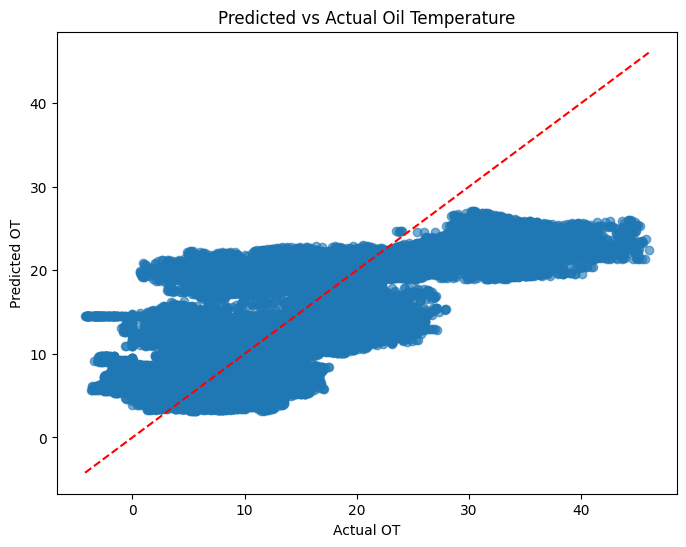

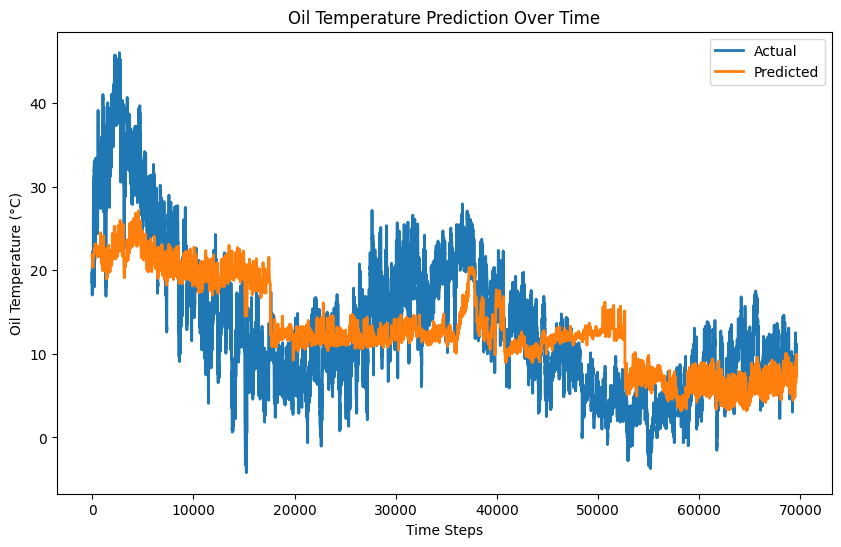

In [24]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

with open("Model_Lasso Regression N_48 points_prior_4 dataset_trans_1.csv.pkl", "rb") as f:
    model = pickle.load(f)
df_test = preprocess_data("trans_1.csv", 48, 4)
selected_features = model.feature_names_in_
print(model.feature_names_in_)

X_test = df_test[selected_features].copy()

# Separate features (X) and target (y)
  # replace "OT" with your target column name
y_test = df_test["OT"]

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Model_Lasso Regression N_48 points_prior_4 dataset_trans_1.csv")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual OT")
plt.ylabel("Predicted OT")
plt.title("Predicted vs Actual Oil Temperature")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Oil Temperature Prediction Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature (°C)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Lasso from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpi

['rolling_mean_HULL' 'rolling_mean_MUFL' 'rolling_mean_MULL'
 'rolling_mean_LUFL' 'MUFL_lag679' 'MUFL_lag683' 'MUFL_lag684'
 'MUFL_lag685' 'MUFL_lag686' 'MUFL_lag689' 'MUFL_lag768' 'LULL_lag673'
 'LULL_lag766' 'LULL_lag767' 'LULL_lag768' 'year' 'month' 'day' 'dow'
 'hour']
Model_Lasso Regression N_96 points_prior_672 dataset_trans_1.csv.pkl
RMSE: 8.5720
R²: -0.0253


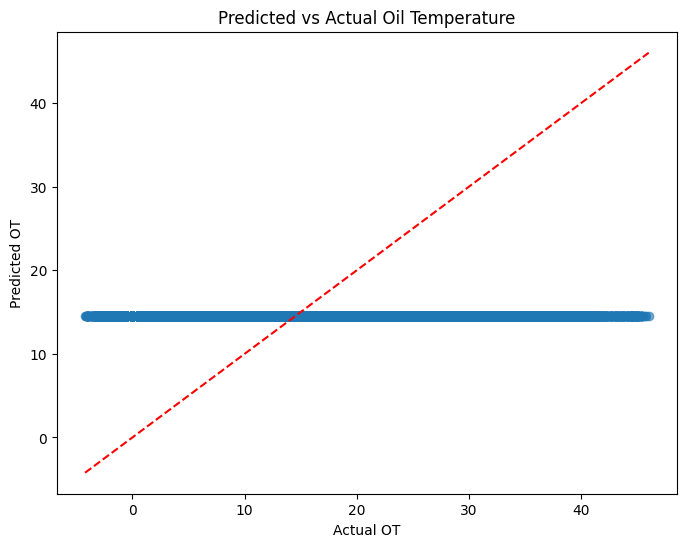

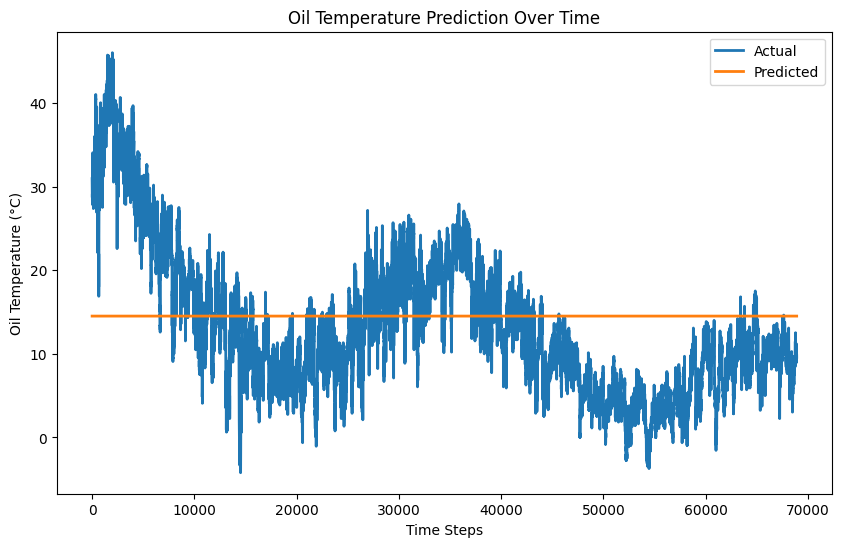

In [27]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

with open("Model_Lasso Regression N_96 points_prior_672 dataset_trans_1.csv.pkl", "rb") as f:
    model = pickle.load(f)
df_test = preprocess_data("trans_1.csv", 96, 672)
selected_features = model.feature_names_in_
print(model.feature_names_in_)

X_test = df_test[selected_features].copy()

# Separate features (X) and target (y)
  # replace "OT" with your target column name
y_test = df_test["OT"]

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Model_Lasso Regression N_96 points_prior_672 dataset_trans_1.csv.pkl")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual OT")
plt.ylabel("Predicted OT")
plt.title("Predicted vs Actual Oil Temperature")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Oil Temperature Prediction Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature (°C)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpi

['rolling_mean_HULL' 'rolling_mean_MULL' 'MUFL_lag678' 'MUFL_lag679'
 'MUFL_lag681' 'MUFL_lag683' 'MUFL_lag684' 'MUFL_lag685' 'MUFL_lag686'
 'MUFL_lag687' 'MUFL_lag688' 'MULL_lag673' 'LULL_lag673' 'LULL_lag716'
 'LULL_lag719' 'LULL_lag720' 'year' 'month' 'day' 'dow']
Model_Ridge Regression N_48 points_prior_672 dataset_trans_1.csv.pkl
RMSE: 6.5764
R²: 0.3983


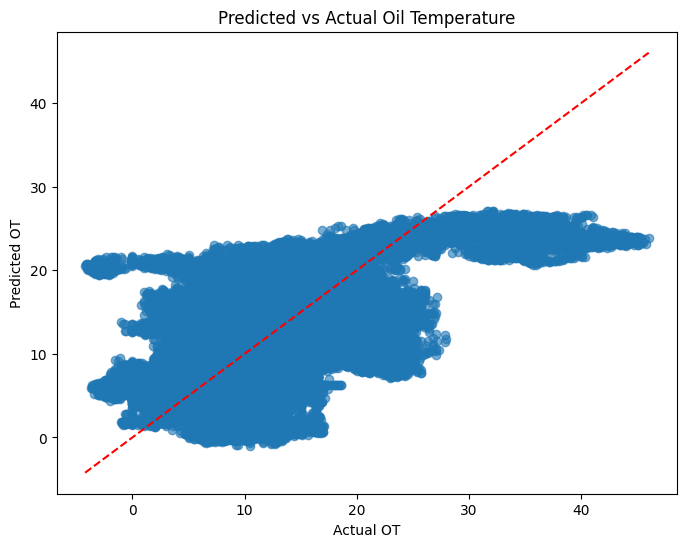

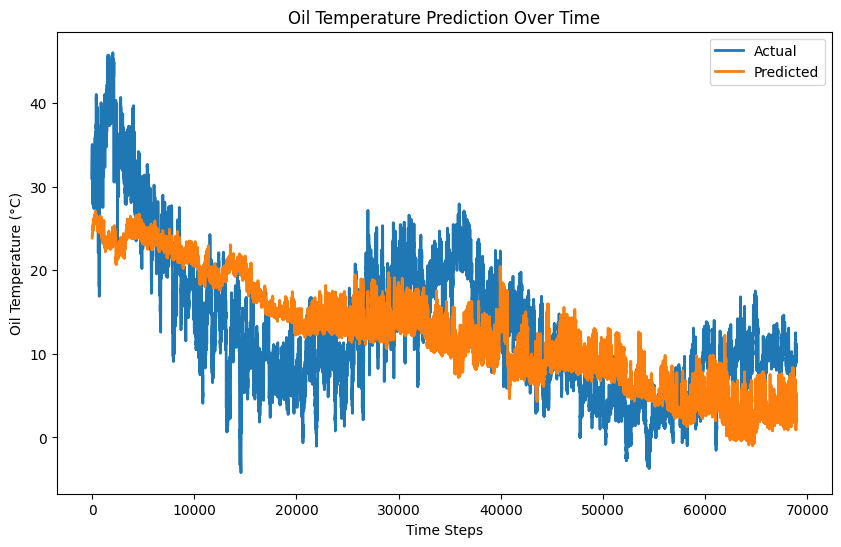

In [28]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

with open("Model_Ridge Regression N_48 points_prior_672 dataset_trans_1.csv.pkl", "rb") as f:
    model = pickle.load(f)
df_test = preprocess_data("trans_1.csv", 48, 672)
selected_features = model.feature_names_in_
print(model.feature_names_in_)

X_test = df_test[selected_features].copy()

# Separate features (X) and target (y)
  # replace "OT" with your target column name
y_test = df_test["OT"]

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Model_Ridge Regression N_48 points_prior_672 dataset_trans_1.csv.pkl")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual OT")
plt.ylabel("Predicted OT")
plt.title("Predicted vs Actual Oil Temperature")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Oil Temperature Prediction Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature (°C)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Try

['rolling_mean_MUFL' 'rolling_mean_MULL' 'rolling_mean_LUFL' 'HUFL_lag7'
 'MUFL_lag7' 'MUFL_lag8' 'MUFL_lag9' 'MUFL_lag12' 'MUFL_lag13'
 'MUFL_lag16' 'MUFL_lag19' 'MUFL_lag42' 'MUFL_lag43' 'MULL_lag34'
 'MULL_lag38' 'MULL_lag42' 'MULL_lag44' 'MULL_lag46' 'year' 'month']
Model_Linear Regression N_96 points_prior_4 dataset_trans_1.csv.pkl
RMSE: 8.2769
R²: 0.0661


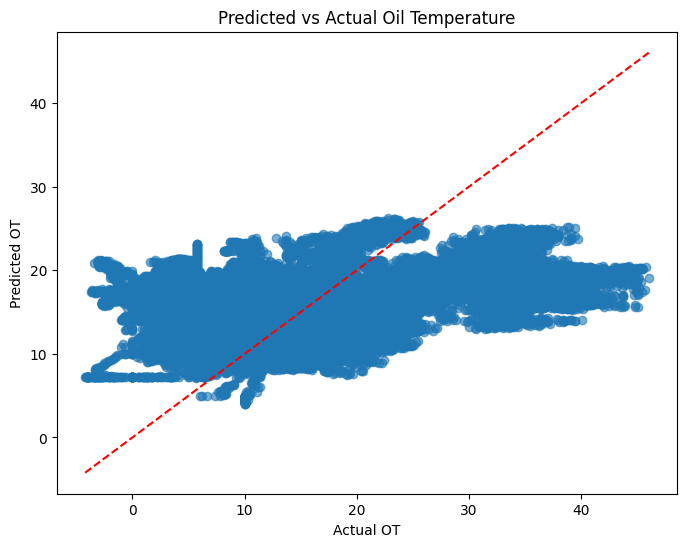

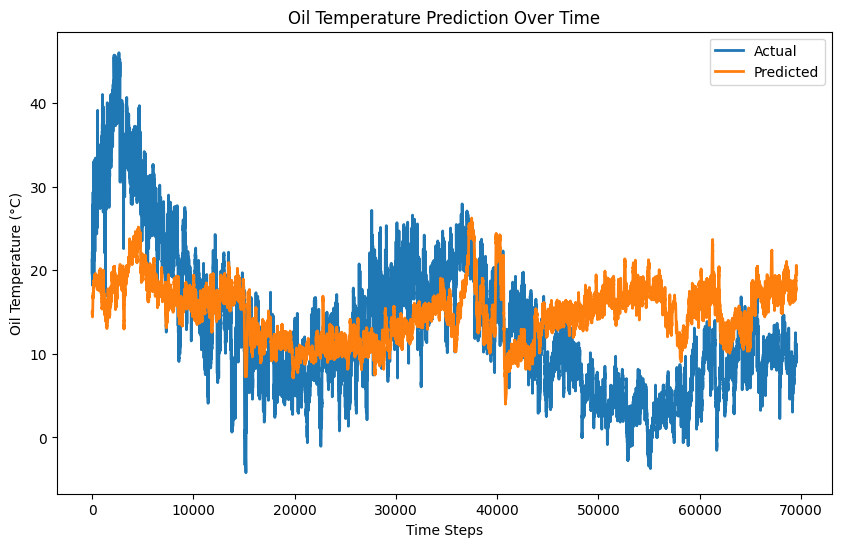

In [35]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

with open("Model_Linear Regression N_96 points_prior_4 dataset_trans_1.csv.pkl", "rb") as f:
    model = pickle.load(f)
df_test = preprocess_data("trans_1.csv", 96, 4)
selected_features = model.feature_names_in_
print(model.feature_names_in_)

X_test = df_test[selected_features].copy()

# Separate features (X) and target (y)
  # replace "OT" with your target column name
y_test = df_test["OT"]

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Model_Linear Regression N_96 points_prior_4 dataset_trans_1.csv.pkl")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual OT")
plt.ylabel("Predicted OT")
plt.title("Predicted vs Actual Oil Temperature")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Oil Temperature Prediction Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature (°C)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<class 'sklearn.pipeline.Pipeline'>
⚠️ Could not find feature_names_in_ — you may need to manually specify the columns.
['scaler', 'model']
STEP: scaler | TYPE: str
STEP: model | TYPE: XGBRegressor


Model_XGBoost Regressor N_96 points_prior_4 dataset_trans_1.csv.pkl
RMSE: 3.0529
R²: 0.8729


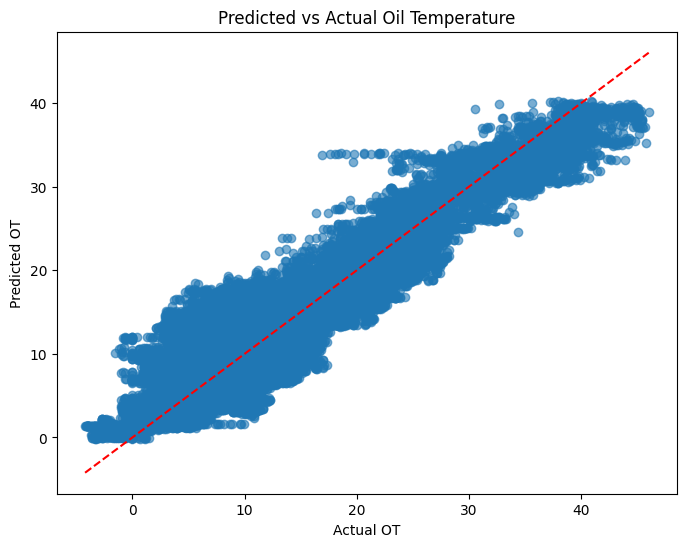

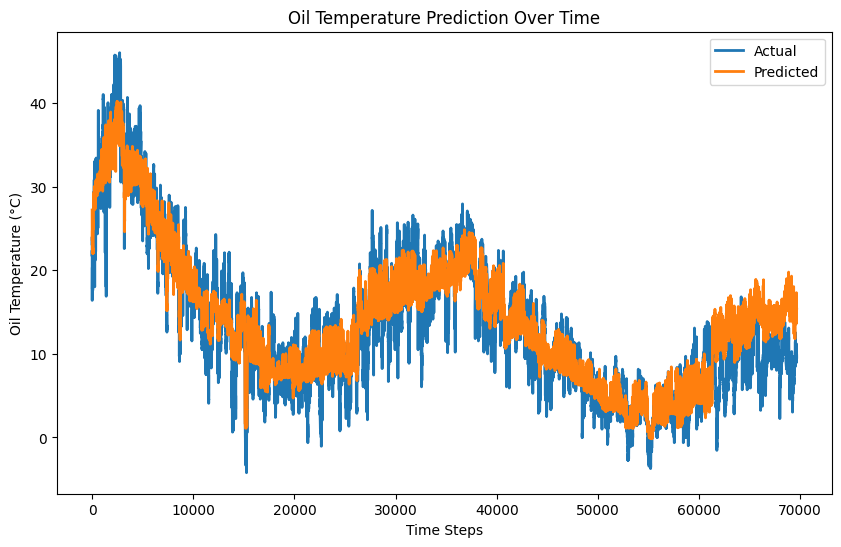

In [47]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

with open("Model_XGBoost Regressor N_24 points_prior_4 dataset_trans_1.csv.pkl", "rb") as f:
    model = pickle.load(f)

print(type(model))
try:
    selected_features = model.feature_names_in_
    print("✅ Features from pipeline:", selected_features)
except AttributeError:
    # If it fails, get them from the first fitted step
    first_step = model.steps[0][1]
    if hasattr(first_step, "feature_names_in_"):
        selected_features = first_step.feature_names_in_
        print("✅ Features from first step:", selected_features)
    else:
        print("⚠️ Could not find feature_names_in_ — you may need to manually specify the columns.")
print([name for name, _ in model.steps])          # step names only
for name, step in model.steps:
    print("STEP:", name, "| TYPE:", type(step).__name__)
df_test = preprocess_data("trans_1.csv", 24, 4)
#selected_features = model.feature_names_in_
#print(model.feature_names_in_)
trained_features = ['rolling_mean_HUFL', 'rolling_mean_MUFL', 'rolling_std_MUFL',
 'rolling_mean_MULL', 'rolling_mean_LUFL', 'rolling_mean_LULL',
 'HUFL_lag26', 'HUFL_lag27', 'HUFL_lag28', 'MUFL_lag6', 'MUFL_lag28',
 'MULL_lag5', 'MULL_lag6', 'MULL_lag7', 'MULL_lag8',
 'LULL_lag19', 'LULL_lag23', 'year', 'month', 'day']
X_test = df_test.reindex(columns=trained_features, fill_value=0).copy()

# Separate features (X) and target (y)
  # replace "OT" with your target column name
y_test = df_test["OT"]

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Model_XGBoost Regressor N_96 points_prior_4 dataset_trans_1.csv.pkl")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual OT")
plt.ylabel("Predicted OT")
plt.title("Predicted vs Actual Oil Temperature")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Oil Temperature Prediction Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature (°C)")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<class 'sklearn.pipeline.Pipeline'>
⚠️ Could not find feature_names_in_ — you may need to manually specify the columns.
['scaler', 'model']
STEP: scaler | TYPE: str
STEP: model | TYPE: XGBRegressor
Train/Val samples: 55591, Test samples: 13897 | gap=0
Model_XGBoost Regressor N_96 points_prior_96 dataset_trans_1.csv.pkl
RMSE: 2.9721
R²: 0.8796


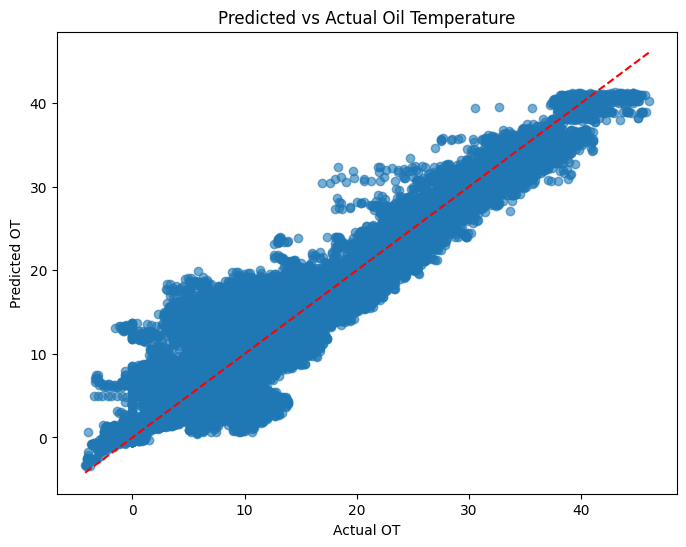

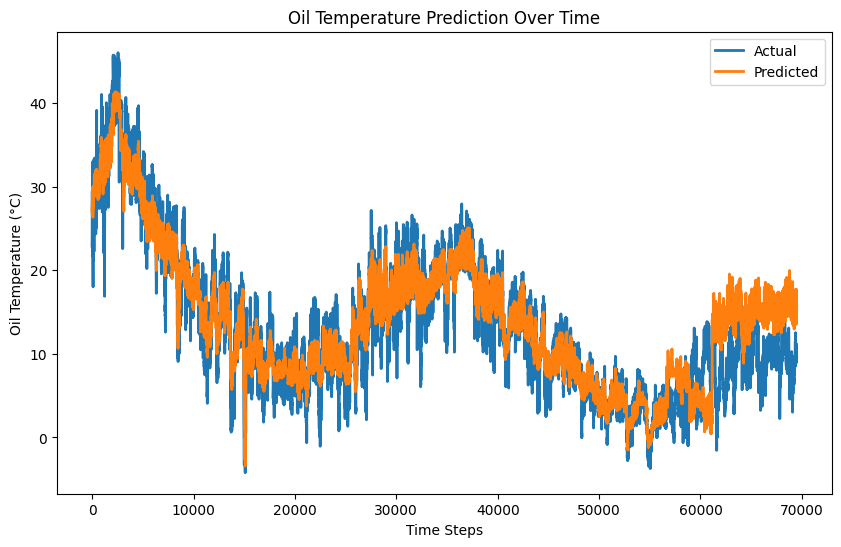

In [49]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

with open("Model_XGBoost Regressor N_96 points_prior_96 dataset_trans_1.csv.pkl", "rb") as f:
    model = pickle.load(f)

print(type(model))
try:
    selected_features = model.feature_names_in_
    print("✅ Features from pipeline:", selected_features)
except AttributeError:
    # If it fails, get them from the first fitted step
    first_step = model.steps[0][1]
    if hasattr(first_step, "feature_names_in_"):
        selected_features = first_step.feature_names_in_
        print("✅ Features from first step:", selected_features)
    else:
        print("⚠️ Could not find feature_names_in_ — you may need to manually specify the columns.")
print([name for name, _ in model.steps])          # step names only
for name, step in model.steps:
    print("STEP:", name, "| TYPE:", type(step).__name__)
df_test = preprocess_data("trans_1.csv", 96, 96)
X_trainval, y_trainval, X_test, y_test, tscv = time_series_split(df_test, "OT")



                # ---- FEATURE SELECTION using RFE ----
base_model = XGBRegressor(
                    objective='reg:squarederror',
                    random_state=42,
                    n_estimators=200,
                    learning_rate=0.05,
                    max_depth=5,
                    subsample=0.8
                )

                # Select top 20 features

#selected_features = model.feature_names_in_
#print(model.feature_names_in_)
rfe = RFE(estimator=base_model, n_features_to_select=20, step=0.1)
rfe.fit(X_trainval, y_trainval)

                # Mask of selected features
trained_features = list(X_trainval.columns[rfe.support_])

X_test = df_test.reindex(columns=trained_features, fill_value=0).copy()

# Separate features (X) and target (y)
  # replace "OT" with your target column name
y_test = df_test["OT"]

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Model_XGBoost Regressor N_96 points_prior_96 dataset_trans_1.csv.pkl")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual OT")
plt.ylabel("Predicted OT")
plt.title("Predicted vs Actual Oil Temperature")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Oil Temperature Prediction Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature (°C)")
plt.show()
